In [1]:
import mne

from crosspy.core.methods import cplv, cplv_pairwise
from crosspy.preprocessing.seeg.support import clean_montage, drop_monopolar_channels
from crosspy.preprocessing.seeg.seeg_utils import create_reference_mask, get_electrode_distance
from crosspy.preprocessing.signal import preprocess_data_morlet

import os

import numpy as np
import glob

import matplotlib.pyplot as plt

import scipy as sp
import scipy.cluster

import sklearn
from sklearn import metrics

import re
import pandas as pd

import pickle

import tqdm

from bids import BIDSLayout

from collections import defaultdict

from statsmodels.stats.multitest import multipletests

import itertools

In [2]:
np.random.seed(42)

In [3]:
from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.166, 0.43, 0.43),
                   (0.33, 0.7, 0.7),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0, 0.6, 0.6)),

         'green': ((0.0, 0.4, 0.4),
                   (0.166, 0.7, 0.7),
                   (0.33, 0.8, 0.8),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0,0.0, 0.0)),

         'blue':  ((0.0, 0.8, 0.8),
                   (0.166, 1.0, 1.0),
                   (0.33, 1.0, 1.0),
                   (0.5, 0.4, 0.4),
                   (0.66, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

ripples_cmap = LinearSegmentedColormap('ripplescmap', cdict1)

In [4]:
NEZ_NEZ_LBL = 1
EZ_EZ_LBL = 2
NEZ_EZ_LBL = 3

In [5]:
def get_frequencies():
    return np.load('gabriele/frequencies.npy')

def get_spectrum(fname, ez_mask):
    res_dict = pickle.load(open(fname, 'rb'))
    data = res_dict['cplv_spectrum']
    mask = np.logical_and(res_dict['reference_mask'].astype(bool), ez_mask)

    plv_spectrum = np.abs(data[:, mask]).mean(axis=1)
    iplv_spectrum = np.abs(np.imag(data[:, mask])).mean(axis=1)
    
    return plv_spectrum, iplv_spectrum

def get_spectrum_by_bins(data, ez_mask, distance_matrix):
    ref_mask = data['reference_mask'].astype(bool)
    spectrum = data['cplv_spectrum']
    surrogate_spectrum = data['surrogate_spectrum']
    
    n_bins = len(distance_bins) - 1
    dists_binned = np.digitize(distance_matrix, bins=distance_bins) - 1
    
    plv_binned = np.zeros((n_bins, spectrum.shape[0]))
    iplv_binned = np.zeros((n_bins, spectrum.shape[0]))
    plv_k = np.zeros((n_bins, spectrum.shape[0]))
    iplv_k = np.zeros((n_bins, spectrum.shape[0]))
    
    for bin_idx in range(n_bins):
        bin_mask = (dists_binned == bin_idx)
        
        mask = np.triu(ref_mask & ez_mask & bin_mask, 1)

        plv_masked = np.abs(spectrum[:, mask])
        iplv_masked = np.abs(np.imag(spectrum[:, mask]))
            
        plv_surr_values = np.abs(surrogate_spectrum[:,mask]).mean(axis=1, keepdims=True)*3.52
        iplv_surr_values = np.abs(np.imag(surrogate_spectrum[:,mask])).std(axis=1, keepdims=True)*3.52
        
        plv_binned[bin_idx] = plv_masked.mean(axis=1)
        iplv_binned[bin_idx] = iplv_masked.mean(axis=1)
        
        plv_k[bin_idx] = np.mean(plv_masked >= plv_surr_values, axis=1)
        iplv_k[bin_idx] = np.mean(iplv_masked >= iplv_surr_values, axis=1)
    
    return plv_binned, iplv_binned, plv_k, iplv_k

def get_replacement_map(labels_x, labels_y, n_clusters):
    def _cluster_similarity(x_idx, y_idx):
        return 1 - sp.spatial.distance.jaccard(labels_x == x_idx,  labels_y == y_idx)

    sim_matrix = np.zeros((n_clusters, n_clusters))

    for i in range(n_clusters):
        for j in range(n_clusters):
            sim_matrix[i,j] = _cluster_similarity(i, j)
    
    return {source:target for source, target in zip(*sp.optimize.linear_sum_assignment(-1*sim_matrix))}

def label_independent_similarity(labels_x, labels_y, n_clusters):
    labels_normalizer = get_replacement_map(labels_x, labels_y, n_clusters)
    labels_x_normed = np.array([labels_normalizer[l] for l in labels_x])
    
    return np.mean(labels_x_normed == labels_y)

def is_bipolar(x):
    a, c = x.split('-')
    
    return len(c) > 0


def create_ez_mask(ez_chans):
    n_chans = len(ez_chans)
    nez_nez_mask = np.zeros((n_chans, n_chans), dtype=bool)
    ez_ez_mask = np.zeros((n_chans, n_chans), dtype=bool)
    ez_nez_mask = np.zeros((n_chans, n_chans), dtype=bool)
    
    for i in range(n_chans):
        for j in range(n_chans):
            nez_nez_mask[i,j] = (ez_chans[i] == 0 and ez_chans[j] == 0) and ref_mask[i,j]
            ez_ez_mask[i,j] = (ez_chans[i] == 1 and ez_chans[j] == 1) and ref_mask[i,j]
            ez_nez_mask[i,j] = ((ez_chans[i] == 1 and ez_chans[j] == 0) or (ez_chans[i] == 0 and ez_chans[j] == 1)) and ref_mask[i,j]
    
    nez_nez_mask = np.triu(nez_nez_mask, 1)
    ez_ez_mask = np.triu(ez_ez_mask, 1)
    ez_nez_mask = np.triu(ez_nez_mask, 1)
    
    return nez_nez_mask, ez_ez_mask, ez_nez_mask

def create_ez_labels(ez_chans):
    n_chans = len(ez_chans)
    res = np.zeros((n_chans, n_chans), dtype=int)
    
    for i in range(n_chans):
        for j in range(n_chans):
            if (ez_chans[i] == 0 and ez_chans[j] == 0):
                res[i,j] = NEZ_NEZ_LBL
            elif (ez_chans[i] == 1 and ez_chans[j] == 1):
                res[i,j] = EZ_EZ_LBL
            elif ((ez_chans[i] == 1 and ez_chans[j] == 0) or (ez_chans[i] == 0 and ez_chans[j] == 1)):
                res[i,j] = NEZ_EZ_LBL
                
    return res

In [6]:
df = pd.read_csv('../seeg_phases/data/SEEG_redux_BIDS/convert_results.csv')
df_num_idx = df.set_index('subject_number')

header=['subject', 'contact', 'EZ', 'GMPI']
ez_data = pd.read_csv('202001_SEEG_ripple_Cohort_Contacts.csv', sep=';', header=None)
ez_grouped = ez_data.groupby(0)

cluster_data = pd.read_csv('Subject_agg_cluster_labels.csv')
subject_to_cluster = cluster_data.set_index('subject_number')

In [7]:
frequencies = get_frequencies()
distance_bins = [0,  32,  45,  60, 137]

small_bins = np.array([  0.24252895,  18.30926768,  23.0868541 ,  26.71645727,
        29.7989191 ,  32.69016637,  35.31417127,  37.98887578,
        40.51194828,  43.01399249,  45.57939557,  48.27752546,
        51.00922561,  53.92323356,  56.99517631,  60.56803472,
        64.54383394,  68.99321803,  74.81033767,  83.68959194,
       137.4912635 ])
small_mids = (small_bins[1:] + small_bins[:-1])/2

In [8]:
all_results = list()

spectrum_by_cluster = defaultdict(list)

subject_numbers = list()

root_path = os.path.join('../seeg_phases/data', 'SEEG_redux_BIDS')
layout = BIDSLayout(root_path)

all_distances = list()

for subject in tqdm.tqdm_notebook(layout.get(target='subject', extension='edf')): 
    subj_num = int(subject.entities['subject'])
    subj_name = df_num_idx.loc[subj_num]['name']
    subj_ez = ez_grouped.get_group(subj_name).set_index(1)
    
    if subj_num in {36}:
        continue

    subj_cluster = subject_to_cluster.loc[subj_num]['subject_cluster']
    
    if subj_cluster == 4:
        continue

    res_fname = 'derivatives/plv_spectrum_no_ez/sub-{}_spectrum_with_lp.pickle'.format(subject.entities['subject'])
    montage_filename = os.path.join(subject.dirname,  'sub-{}_montage.tcsv'.format(subject.entities['subject']))
    electrodes_filename = os.path.join(subject.dirname,  'sub-{}_electrodes.tcsv'.format(subject.entities['subject']))
    
    res_data = pickle.load(open(res_fname, 'rb'))
        
    ref_mask = np.triu(res_data['reference_mask'].astype(bool), 1)
    
    montage = pd.read_csv(montage_filename, sep='\t')
    montage = montage[montage['name'].apply(is_bipolar)]
    ch_names = montage['name'].values
    
    electrodes = pd.read_csv(electrodes_filename, sep='\t')
    distance_matrix = get_electrode_distance(ch_names, electrodes_filename)
    distance_labels = np.digitize(distance_matrix, small_bins) - 1
    
    ez_chans = np.array([int(subj_ez.loc[ch][2] != 0) for ch in ch_names])
    epleptic_labels = create_ez_labels(ez_chans)
    
    all_distances.extend(distance_matrix[ref_mask])
    
    subj_res = np.zeros((len(frequencies), len(small_bins) - 1, 3))
    
    for bin_label, ez_label in itertools.product(range(len(small_bins) - 1), range(3)):
        dist_mask = (distance_labels == bin_label)
        ez_mask = (epleptic_labels == ez_label + 1)
        
        type_mask = ref_mask & dist_mask & ez_mask
        subj_res[:, bin_label, ez_label] = np.abs(res_data['cplv_spectrum'][:, type_mask]).mean(axis=1)
        
    all_results.append(subj_res)
#     subj_res = np.zeros((len(frequencies), ))
    
#     subj_plv_whole = np.abs(res_data['cplv_spectrum'][:, ref_mask & ez_mask]).mean(axis=1)
    
#     subj_plv, subj_iplv, subj_plv_k, subj_iplv_k = get_spectrum_by_bins(res_data, ez_mask, distance_matrix)

#     spectrum_by_cluster[subj_cluster].append(subj_plv_whole)


        
#     plv_spectrum.append(subj_plv)
#     iplv_spectrum.append(subj_iplv)
#     plv_k.append(subj_plv_k)
#     iplv_k.append(subj_iplv_k)
    
#     surr_plv.append(np.abs(res_data['surrogate_spectrum'][:, ref_mask & ez_mask]).mean(axis=1))
#     surr_iplv.append(np.abs(np.imag(res_data['surrogate_spectrum'][:, ref_mask & ez_mask])).mean(axis=1))
    
#     subject_numbers.append(subj_num)
    
# plv_spectrum = np.array(plv_spectrum)
# iplv_spectrum = np.array(iplv_spectrum)
# plv_k = np.array(plv_k)
# iplv_k = np.array(iplv_k)
# surr_plv = np.array(surr_plv)
# surr_iplv = np.array(surr_iplv)

all_results = np.array(all_results)

/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice.
/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [9]:
frequencies_indicies = [
                        slice(0, 9),
                        slice(9, 17),
                        slice(17, 32),
                        slice(32, 40),
                        slice(40,50)
                        ]

In [10]:
def estimate_mean_with_bootstrap(spectrum, N_rounds=1000):
    all_indices = np.arange(spectrum.shape[0])
        
    res = np.zeros((N_rounds, ) + spectrum.shape[2:])
    for idx in range(N_rounds):
        round_indices = np.random.choice(all_indices, size=all_indices.shape[0])
        res[idx] = np.nanmean(spectrum[round_indices], axis=(0,1))
        
    return res



def bootstrap_group_diff(spectrum_nez, spectrum_ez, N_rounds=1000):
    spectrum_both = np.vstack([spectrum_nez, spectrum_ez])
    labels = np.array([0]*spectrum_nez.shape[0] + [1]*spectrum_ez.shape[0])
    
    idx_concat = np.arange(labels.shape[0])
    idx_single = np.arange(spectrum_nez.shape[0])
    
    bootstrapped_data = np.zeros((N_rounds, spectrum_nez.shape[1]))
    surr_data = np.zeros((N_rounds, spectrum_nez.shape[1]))
    
    for idx in range(N_rounds):
        np.random.shuffle(labels)
        boot_idx = np.random.choice(idx_single, size=idx_single.shape[0])
        
        surr_data[idx] = np.nanmean(spectrum_both[labels == 1], axis=0) - np.nanmean(spectrum_both[labels == 0], axis=0)
        bootstrapped_data[idx] = np.nanmean(spectrum_ez[boot_idx], axis=0) - np.nanmean(spectrum_nez[boot_idx], axis=0)
    
    return bootstrapped_data, surr_data
    

In [11]:
# freq_name = '{:.1f}Hz-{:.1f}Hz'.format(frequencies[freq_slice.start], frequencies[freq_slice.stop-1])
# pd.DataFrame({'Distance_bin': small_mids[1:], 'p-value':pvals[1:], 'Frequencies': freq_name})

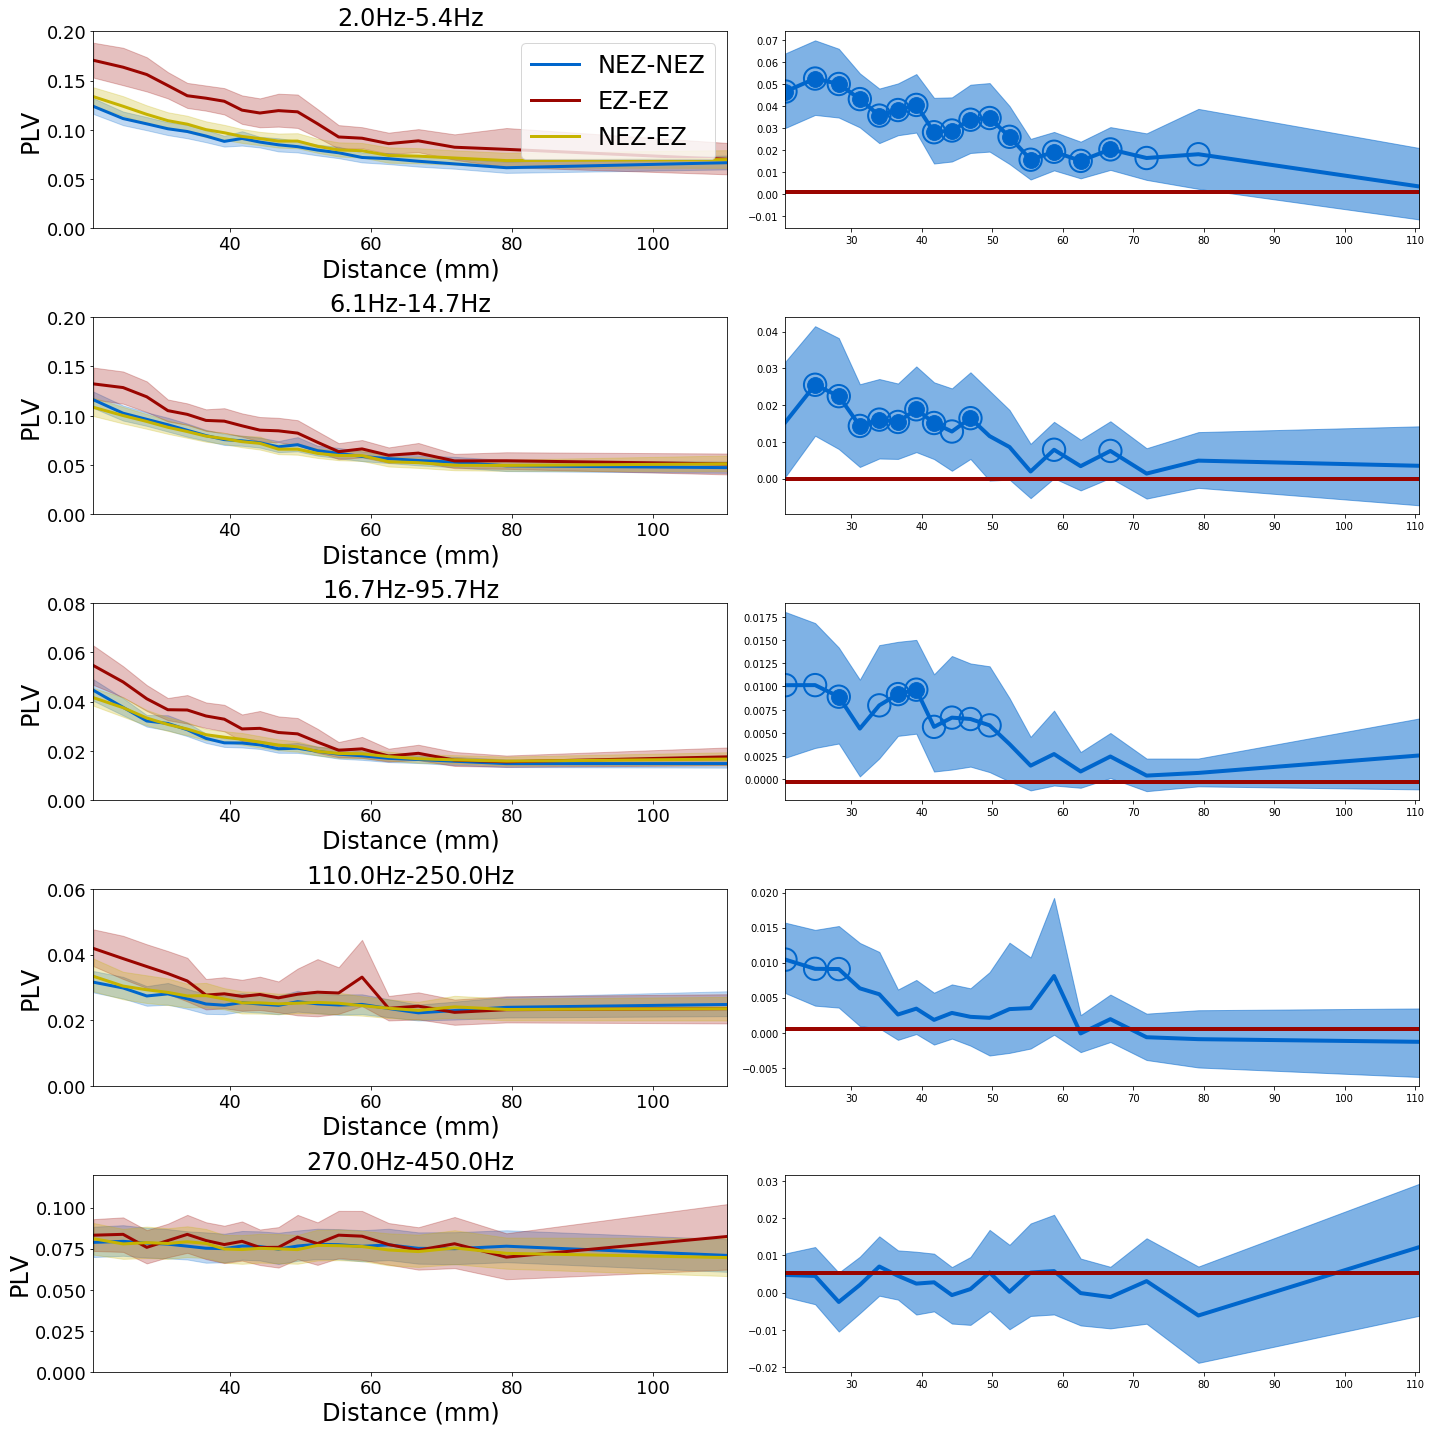

In [25]:
pvals_df_list = list()

fig, axes = plt.subplots(figsize=(20, 20), nrows=5, ncols=2)

ez_cols = [ripples_cmap(0), ripples_cmap(0.99), ripples_cmap(0.7)]
ez_names = ['NEZ-NEZ', 'EZ-EZ', 'NEZ-EZ']

h_by_ez = dict()
h_orig_by_ez = dict()
bootstrapped_by_ez = defaultdict(dict)

for (ax_row, freq_slice), ez_type in itertools.product(zip(axes, frequencies_indicies), (0,1,2)):  
    vals_bootstrapped = estimate_mean_with_bootstrap(all_results[:, freq_slice, :, ez_type])
    vals_mean = vals_bootstrapped.mean(axis=0)
    vals_25, vals_975 = np.percentile(vals_bootstrapped, (5, 95), axis=0)
    
    ax_row[0].plot(small_mids[1:], vals_mean[1:], color=ez_cols[ez_type], label=ez_names[ez_type], lw=3)
    ax_row[0].fill_between(small_mids[1:], vals_25[1:], vals_975[1:], color=ez_cols[ez_type], alpha=0.25)
    
    bootstrapped_by_ez[(freq_slice.start, freq_slice.stop)][ez_type] = vals_bootstrapped
    
for ax, freq_slice in zip(axes[:,1], frequencies_indicies):
    group_diff = np.nanmean(all_results[:, freq_slice, :, 0] - all_results[:, freq_slice, :, 1], axis=(0,1))
    diff, diff_surr = bootstrap_group_diff(all_results[:, freq_slice, :, 0].mean(axis=1),
                     all_results[:, freq_slice, :, 1].mean(axis=1), 1000)
    
    pvals = ((diff_surr <= group_diff).sum(axis=0) + 1)/(diff_surr.shape[0] + 1)
    h_corrected, pv_corrected, _, _ =  multipletests(pvals, alpha=.05, method='fdr_bh')
    h_corrected[0] = False
    h = pvals <= 0.05
    h[0] = False

    surr_level = np.percentile(np.min(diff_surr, axis=1), 95)
    
    diff_5, diff_95 = np.percentile(diff, (5,95), axis=0)
    
    ax.plot(small_mids[1:], np.nanmean(diff, axis=0)[1:], lw=4, color=ripples_cmap(0))
    ax.fill_between(small_mids[1:], diff_5[1:], diff_95[1:], color=ripples_cmap(0), alpha=0.5)
    
    ax.plot([small_mids[1], small_mids[~0]], [surr_level, surr_level], color=ripples_cmap(0.99), lw=4)
    
    ax.scatter(small_mids[h_corrected], np.nanmean(diff, axis=0)[h_corrected], color=ripples_cmap(0), s=250)
    ax.scatter(small_mids[h], np.nanmean(diff, axis=0)[h], color=ripples_cmap(0), s=500, facecolors='none', linewidth=2)
    
    freq_name = '{:.1f}Hz-{:.1f}Hz'.format(frequencies[freq_slice.start], frequencies[freq_slice.stop-1])
    df = pd.DataFrame({'Distance_bin': small_mids[1:], 'p-value':pvals[1:],
                       'p-value_corrected': pv_corrected[1:], 'Frequencies': freq_name})
    pvals_df_list.append(df)
    
    h_by_ez[(freq_slice.start, freq_slice.stop)] = h_corrected
    h_orig_by_ez[(freq_slice.start, freq_slice.stop)] = h
    
for freq_slice, ax, y_max in zip(frequencies_indicies, axes[:,0], [0.2, 0.2, 0.08, 0.06, 0.12]):
#     ax.set_xticks(np.arange(20))
    ax.tick_params(labelsize=18)
#     ax.set_xticks(small_bins[1::4].tolist() + small_bins[-2:].tolist())
#     ax.set_xticks(small_mids[1::4].tolist() + small_mids[-2:].tolist())
    ax.set_xticks(np.arange(20, 120, 20))
#     ax.set_xticklabels(np.round(small_bins, 1)[::2])
    ax.set_xlabel('Distance (mm)', fontsize=24)
    ax.set_ylabel('PLV', fontsize=24)
    ax.set_title('{:.1f}Hz-{:.1f}Hz'.format(frequencies[freq_slice.start], frequencies[freq_slice.stop-1]), fontsize=24)
    ax.set_ylim([0, y_max])
    
for ax in axes.flatten():
    ax.set_xlim([small_mids[1], small_mids[~0]])

axes[0,0].legend(fontsize=24)

fig.tight_layout()
fig.savefig('figure_7_supp.pdf')

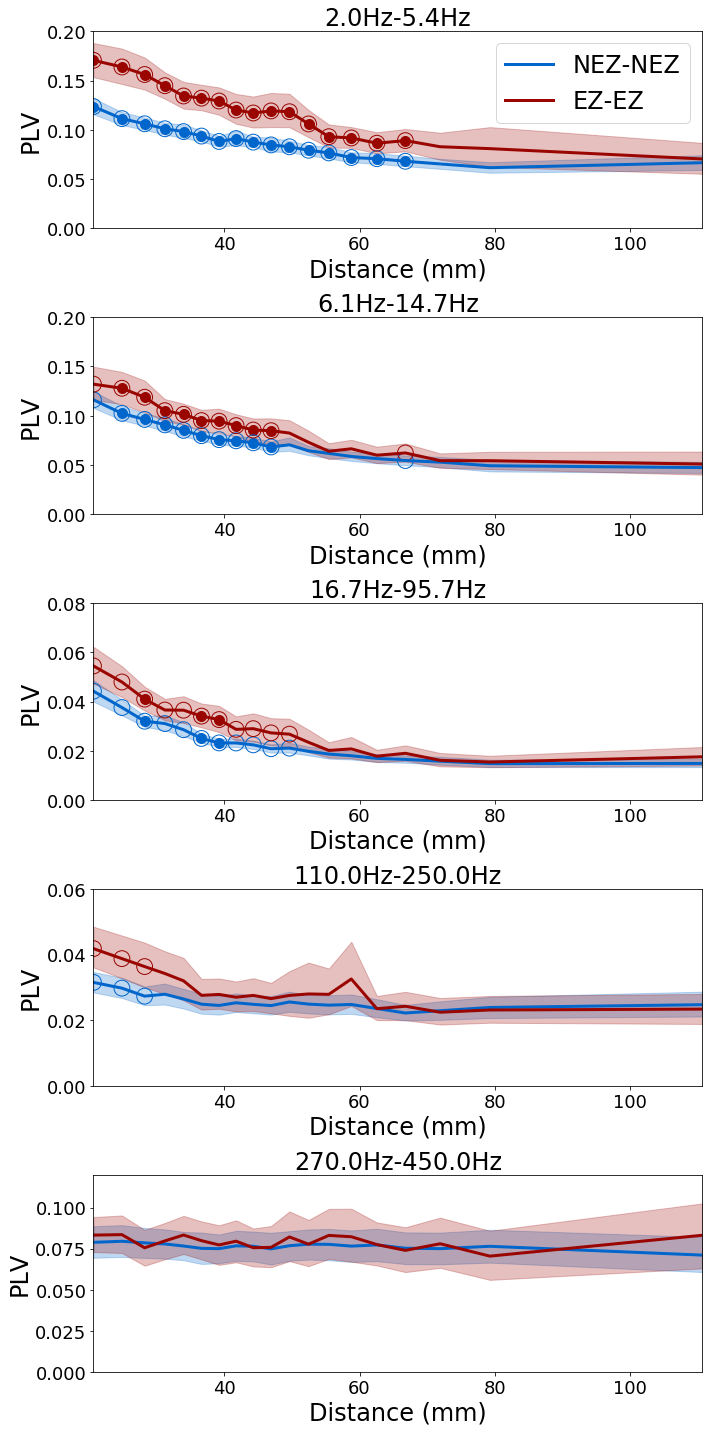

In [16]:
fig, axes = plt.subplots(figsize=(10, 20), nrows=5, ncols=1)

ez_cols = [ripples_cmap(0), ripples_cmap(0.99), ripples_cmap(0.7)]
ez_names = ['NEZ-NEZ', 'EZ-EZ', 'NEZ-EZ']



for (ax_row, freq_slice), ez_type in itertools.product(zip(axes, frequencies_indicies), (0,1)):  
    vals_bootstrapped = bootstrapped_by_ez[(freq_slice.start, freq_slice.stop)][ez_type]
    vals_mean = vals_bootstrapped.mean(axis=0)
    vals_25, vals_975 = np.percentile(vals_bootstrapped, (5, 95), axis=0)
    
    ax_row.plot(small_mids[1:], vals_mean[1:], color=ez_cols[ez_type], label=ez_names[ez_type], lw=3)
    ax_row.fill_between(small_mids[1:], vals_25[1:], vals_975[1:], color=ez_cols[ez_type], alpha=0.25)
    
#     bootstrapped_by_ez[(freq_slice.start, freq_slice.stop)][ez_type] = vals_mean

for ax, freq_slice in zip(axes, frequencies_indicies):
    group_diff = np.nanmean(all_results[:, freq_slice, :, 0] - all_results[:, freq_slice, :, 1], axis=(0,1))
    diff, diff_surr = bootstrap_group_diff(all_results[:, freq_slice, :, 0].mean(axis=1),
                     all_results[:, freq_slice, :, 1].mean(axis=1), 1000)
    
#     pvals = ((diff_surr <= group_diff).sum(axis=0) + 1)/(diff_surr.shape[0] + 1)
#     pv_corrected, _, _ =  multipletests(pvals, alpha=.05, method='fdr_bh')
#     h_corrected[0] = False
#     h = pvals <= 0.05
#     h[0] = False
    h_corrected = h_by_ez[(freq_slice.start, freq_slice.stop)]
    h_orig = h_orig_by_ez[(freq_slice.start, freq_slice.stop)]
#     h = np.logical_xor(h, h_corrected)

    surr_level = np.percentile(np.min(diff_surr, axis=1), 95)
    
    diff_5, diff_95 = np.percentile(diff, (5,95), axis=0)
        
    ax.scatter(small_mids[h_corrected], bootstrapped_by_ez[(freq_slice.start, freq_slice.stop)][0].mean(axis=0)[h_corrected], color=ripples_cmap(0), s=100)
    ax.scatter(small_mids[h_corrected], bootstrapped_by_ez[(freq_slice.start, freq_slice.stop)][1].mean(axis=0)[h_corrected], color=ripples_cmap(0.99), s=100)
    ax.scatter(small_mids[h_orig], bootstrapped_by_ez[(freq_slice.start, freq_slice.stop)][0].mean(axis=0)[h_orig], facecolors='none', color=ripples_cmap(0), s=250)
    ax.scatter(small_mids[h_orig], bootstrapped_by_ez[(freq_slice.start, freq_slice.stop)][1].mean(axis=0)[h_orig], facecolors='none', color=ripples_cmap(0.99), s=250)
#     ax.scatter(small_mids[h], np.nanmean(diff, axis=0)[h], color=ripples_cmap(0), s=500, facecolors='none', linewidth=2)
    
    freq_name = '{:.1f}Hz-{:.1f}Hz'.format(frequencies[freq_slice.start], frequencies[freq_slice.stop-1])
    df = pd.DataFrame({'Distance_bin': small_mids[1:], 'p-value':pvals[1:],
                       'p-value_corrected': pv_corrected[1:], 'Frequencies': freq_name})
    pvals_df_list.append(df)
    
for freq_slice, ax, y_max in zip(frequencies_indicies, axes, [0.2, 0.2, 0.08, 0.06, 0.12]):
#     ax.set_xticks(np.arange(20))
    ax.tick_params(labelsize=18)
#     ax.set_xticks(small_bins[1::4].tolist() + small_bins[-2:].tolist())
#     ax.set_xticks(small_mids[1::4].tolist() + small_mids[-2:].tolist())
    ax.set_xticks(np.arange(20, 120, 20))
#     ax.set_xticklabels(np.round(small_bins, 1)[::2])
    ax.set_xlabel('Distance (mm)', fontsize=24)
    ax.set_ylabel('PLV', fontsize=24)
    ax.set_title('{:.1f}Hz-{:.1f}Hz'.format(frequencies[freq_slice.start], frequencies[freq_slice.stop-1]), fontsize=24)
    ax.set_ylim([0, y_max])
    ax.set_xlim([small_mids[1], small_mids[~0]])
    
axes[0].legend(fontsize=24)

fig.tight_layout()
fig.savefig('figure_7.pdf')

In [27]:
pd.concat(pvals_df_list).to_csv('fig_07_ez_nez_diff_p-val.csv', index=False)